In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop

# from orig_data import prepare_spiking_data_loaders
from data import prepare_v1_dataloaders, SyntheticDataset, BatchPatchesDataLoader, MixedBatchLoader, PerSampleStoredDataset

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model'


In [4]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "stim_crop_win": (slice(15, 35), slice(15, 35)),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [5]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

In [6]:
if config["stim_crop_win"] is not None:
    crop_stim = lambda x: x[..., config["stim_crop_win"][0], config["stim_crop_win"][1]]
else:
    crop_stim = lambda x: x

## Data

In [7]:
config["data"]["v1_data"] = {
    "train_path": os.path.join(DATA_PATH, "datasets", "train"),
    "val_path": os.path.join(DATA_PATH, "datasets", "val"),
    "test_path": os.path.join(DATA_PATH, "orig", "raw", "test.pickle"),
    "image_size": [50, 50],
    "crop": False,
    # "crop": True,
    # "batch_size": 64,
    "batch_size": 20,
    "stim_normalize_mean": 46.236,
    "stim_normalize_std": 21.196,
    "resp_normalize_mean": torch.from_numpy(np.load(
        os.path.join(DATA_PATH, "responses_mean_from_training_dataset.npy")
    )).float(),
    "resp_normalize_std": torch.from_numpy(np.load(
        os.path.join(DATA_PATH, "responses_std_from_training_dataset.npy")
    )).float(),
}

In [8]:
### get data loaders
v1_dataloaders = prepare_v1_dataloaders(**config["data"]["v1_data"])

Train dataset size: 35643. Validation dataset size: 2890. Test dataset size: 500.


stim.shape=torch.Size([20, 1, 50, 50]), resp.shape=torch.Size([20, 10000])
stim.min()=tensor[] -2.181, stim.max()=tensor[] 2.537
resp.min()=tensor[] -1.928, resp.max()=tensor[] 22.648
stim.mean()=tensor[] 0.178, stim.std()=tensor[] 1.235
resp.mean()=tensor[] -0.000, resp.std()=tensor[] 1.012


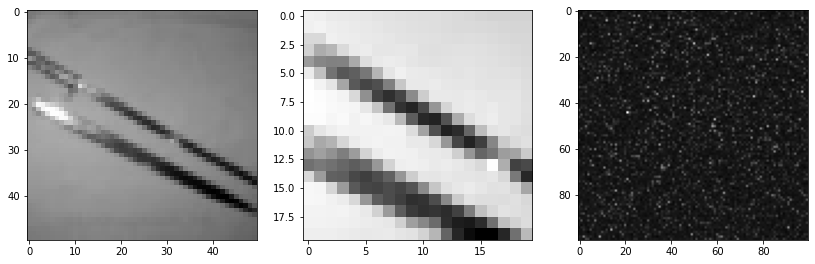

In [9]:
### show data
stim, resp = next(iter(v1_dataloaders["val"]))
print(
    f"{stim.shape=}, {resp.shape=}"
    f"\n{stim.min()=}, {stim.max()=}"
    f"\n{resp.min()=}, {resp.max()=}"
    f"\n{stim.mean()=}, {stim.std()=}"
    f"\n{resp.mean()=}, {resp.std()=}"
)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(stim[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(resp[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

### Synthetic data (generated using the Encoder)

In [10]:
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "responses_mean_from_syn_dataset.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "responses_std_from_syn_dataset.npy"))).float()

config["data"]["syn_data"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=114.457,
            std=51.356,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 20,
        "shuffle": True,
    }
}

In [11]:
syn_datasets = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "train"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "val"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "test"),
        **config["data"]["syn_data"]["dataset"]
    ),
}

syn_dataloaders = {
    "train": DataLoader(
        dataset=syn_datasets["train"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets["val"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets["test"],
        **config["data"]["syn_data"]["dataloader"],
    ),
}

syn_stim.shape=torch.Size([20, 1, 50, 50]), syn_resp.shape=torch.Size([20, 10000])
syn_stim.min()=tensor[] -2.229, syn_stim.max()=tensor[] 2.737
syn_resp.min()=tensor[] -1.767, syn_resp.max()=tensor[] 9.659
syn_stim.mean()=tensor[] 0.231, syn_stim.std()=tensor[] 1.347
syn_resp.mean()=tensor[] -0.033, syn_resp.std()=tensor[] 0.450


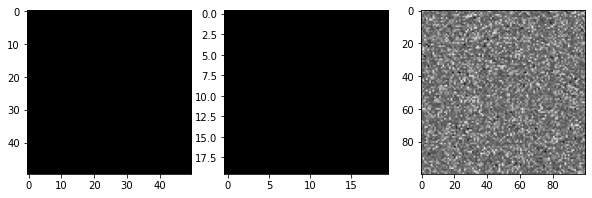

In [12]:
### show data
syn_stim, syn_resp = next(iter(syn_dataloaders["val"]))
print(
    f"{syn_stim.shape=}, {syn_resp.shape=}"
    f"\n{syn_stim.min()=}, {syn_stim.max()=}"
    f"\n{syn_resp.min()=}, {syn_resp.max()=}"
    f"\n{syn_stim.mean()=}, {syn_stim.std()=}"
    f"\n{syn_resp.mean()=}, {syn_resp.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(syn_stim.cpu()[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

## Compare decoders

In [13]:
def eval(model, dataloader, loss_fn, device="cpu"):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (stim, resp) in enumerate(dataloader):
            stim = stim.to(device)
            resp = resp.to(device)

            if resp.ndim == 3:
                resp = resp.mean(dim=1) # average over trials (test V1 dataset)
            
            stim_pred = model(resp)
            loss = loss_fn(stim_pred, stim)
            
            ### log
            val_loss += loss.item()
    
    val_loss /= len(dataloader)
    return val_loss

In [16]:
runs_to_compare = {
    "0%": {
        "run_name": "2023-07-26_21-18-17",
    },
    "25%": {
        "run_name": "2023-08-01_23-35-01",
    },
    "50%": {
        "run_name": "2023-07-30_18-41-19",
    },
    "50% - large": {
        "run_name": "2023-08-02_23-24-44",
    },
    "75%": {
        "run_name": "2023-08-02_23-01-54",
    },
    "100%": {
        "run_name": "2023-07-26_23-25-01",
    },
}

loss_fns = {
    "Log SSIM Loss": SSIMLoss(
        window=config["stim_crop_win"],
        log_loss=True,
        inp_normalized=True,
    ),
    "SSIM Loss": SSIMLoss(
        window=config["stim_crop_win"],
        log_loss=False,
        inp_normalized=True,
    ),
    "MSE Loss": lambda x_hat, x: F.mse_loss(
        standardize(crop_stim(x_hat)),
        standardize(crop_stim(x))
    ),
}

device = "cuda" if torch.cuda.is_available() else "cpu"

Loading 0% model (run name: 2023-07-26_21-18-17)...


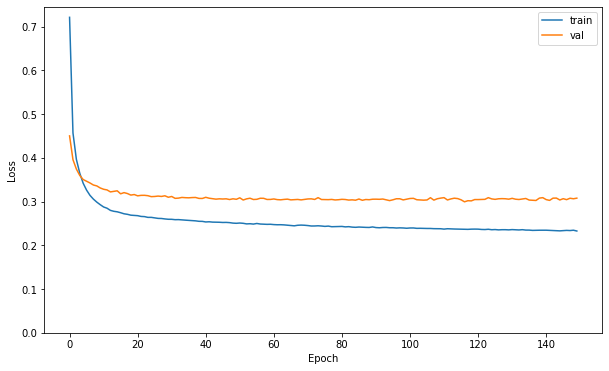

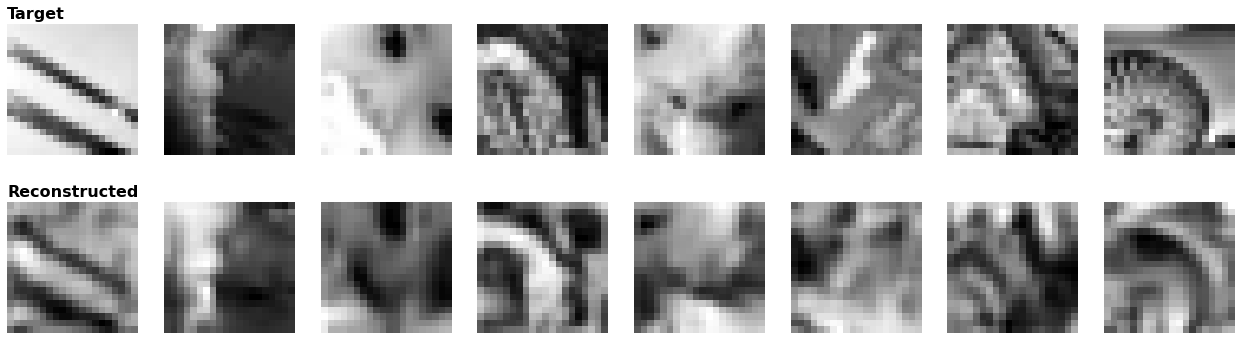

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-07-26_21-18-17/stim_comparison_best.png.
Loading 25% model (run name: 2023-08-01_23-35-01)...


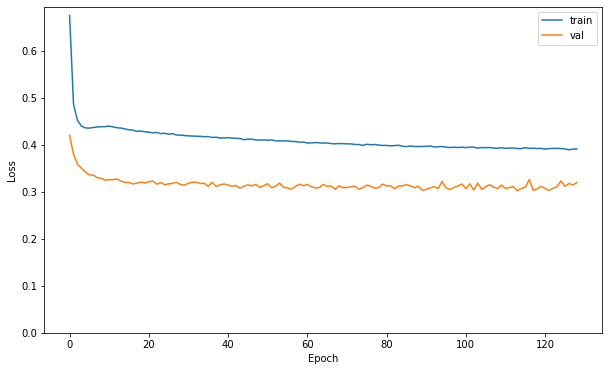

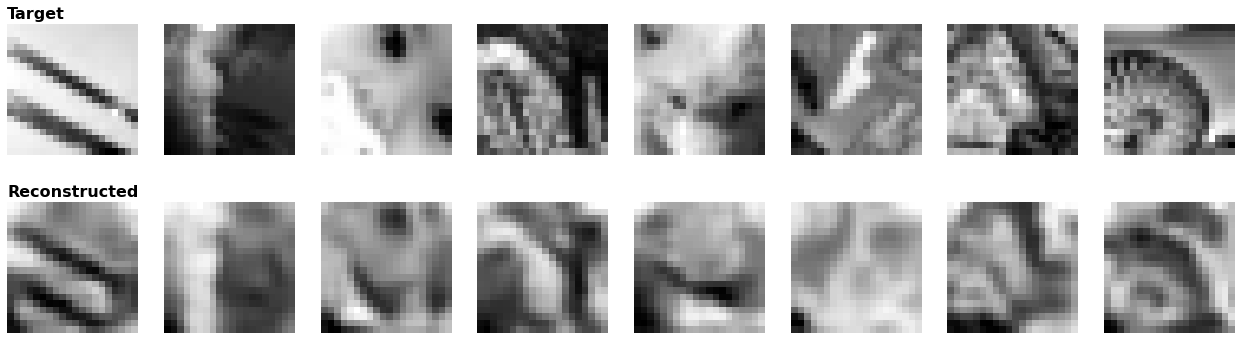

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-08-01_23-35-01/stim_comparison_best.png.
Loading 50% model (run name: 2023-07-30_18-41-19)...


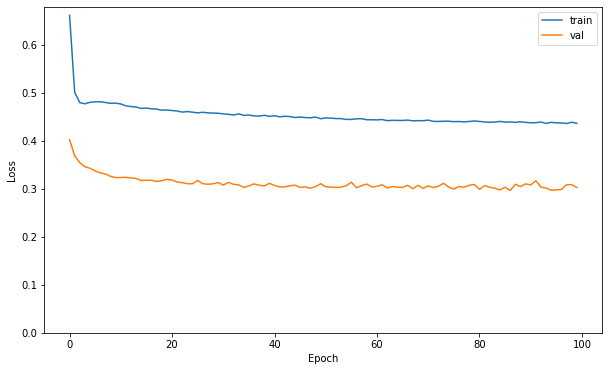

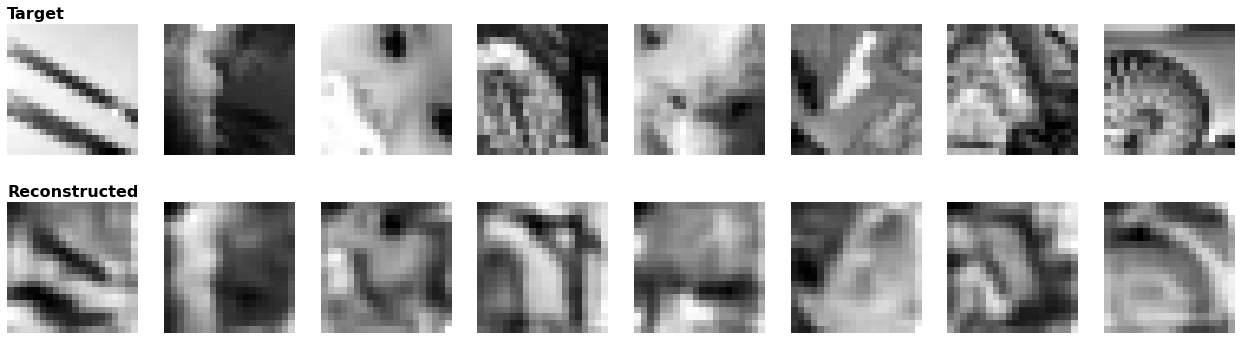

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-07-30_18-41-19/stim_comparison_best.png.
Loading 50% - large model (run name: 2023-08-02_23-24-44)...


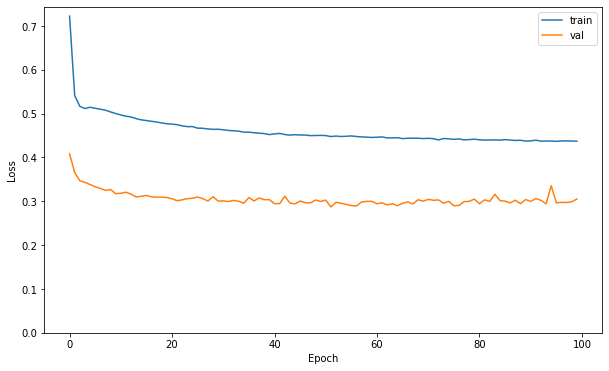

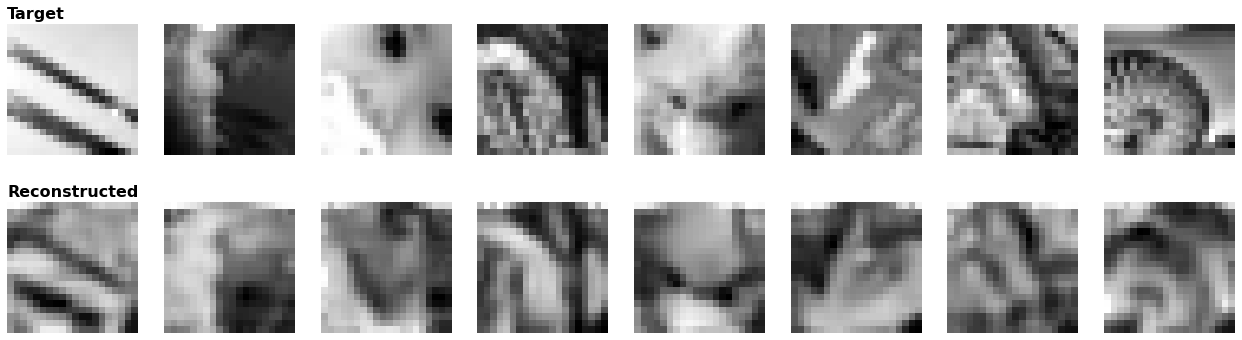

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-08-02_23-24-44/stim_comparison_best.png.
Loading 75% model (run name: 2023-08-02_23-01-54)...


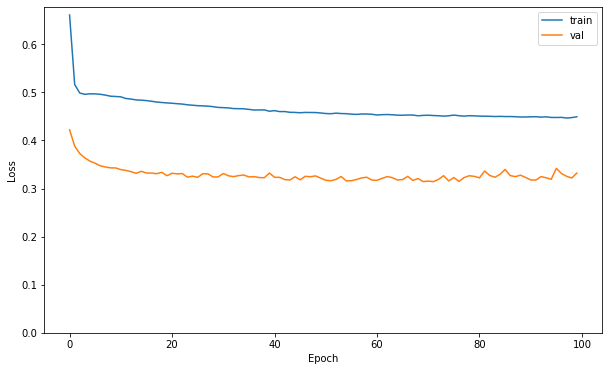

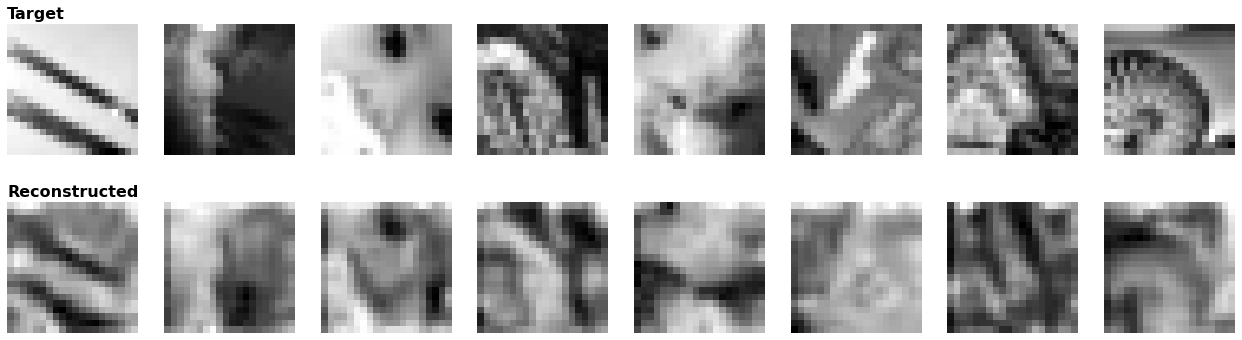

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-08-02_23-01-54/stim_comparison_best.png.
Loading 100% model (run name: 2023-07-26_23-25-01)...


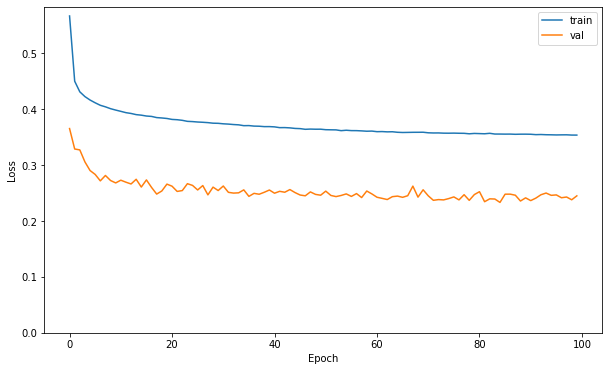

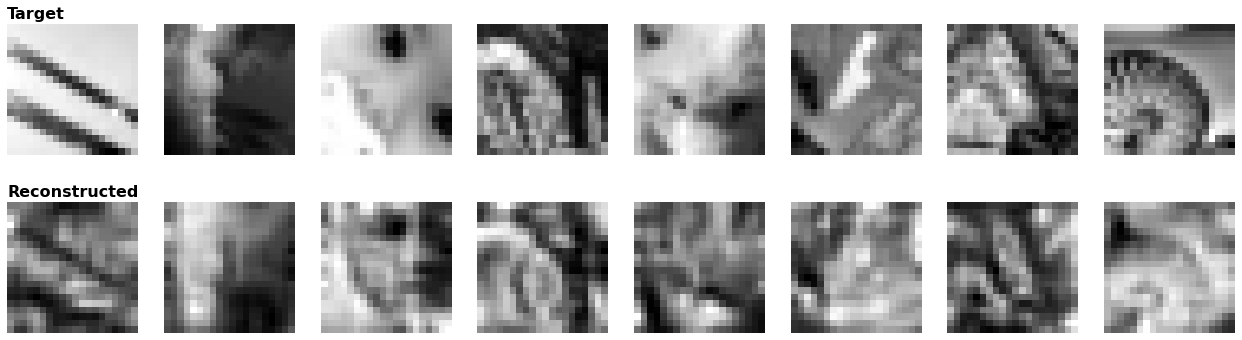

Saved to /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/models/2023-07-26_23-25-01/stim_comparison_best.png.


In [18]:
for k in runs_to_compare.keys():
    run_name = runs_to_compare[k]["run_name"]
    print(f"Loading {k} model (run name: {run_name})...")

    ### load ckpt
    ckpt = torch.load(os.path.join(DATA_PATH, "models", run_name, "decoder.pt"))
    config = ckpt["config"]
    history = ckpt["history"]
    decoder = CNN_Decoder(**config["decoder"]["model"]).to(device)
    decoder.load_state_dict(ckpt["decoder"])
    config["stim_crop_win"] = (slice(15, 35), slice(15, 35))
    best = ckpt["best"]

    ### plot losses
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(history["train_loss"], label="train")
    ax.plot(history["val_loss"], label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_ylim(0, None)
    ax.legend()
    plt.show()

    ### plot reconstructions of the final model
    decoder.load_state_dict(best["model"])
    stim_pred_best = decoder(resp.to(device)).detach().cpu()
    plot_comparison(
        target=crop_stim(stim[:8]).cpu(),
        pred=crop_stim(stim_pred_best[:8]).cpu(),
        save_to=os.path.join(config["dir"], "stim_comparison_best.png")
    )

    ### eval
    test_losses = dict()
    for loss_fn_name, loss_fn in loss_fns.items():
        test_losses[loss_fn_name] = eval(
            model=decoder,
            dataloader=v1_dataloaders["test"],
            loss_fn=loss_fn,
            device=device,
        )

    ### save
    runs_to_compare[k]["test_losses"] = test_losses
    runs_to_compare[k]["train_loss"] = history["train_loss"]
    runs_to_compare[k]["val_loss"] = history["val_loss"]
    runs_to_compare[k]["config"] = config
    runs_to_compare[k]["best_val_loss"] = best["val_loss"]

In [19]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height.
    https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

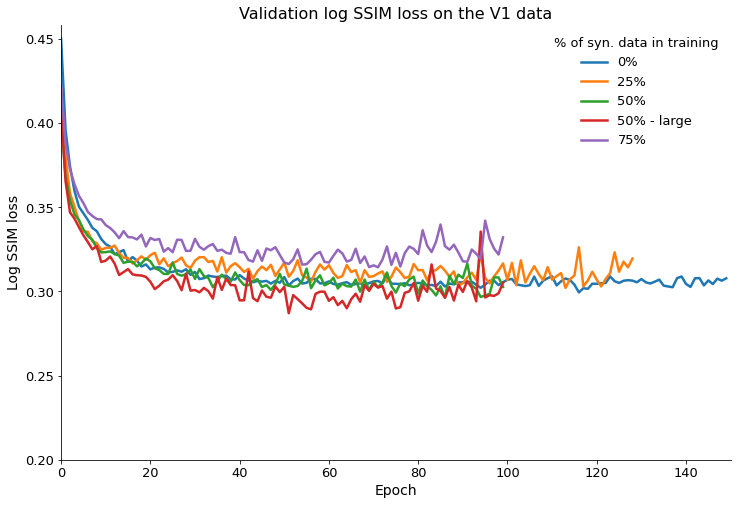

In [23]:
### plot losses together
to_plot = "val_loss"
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for k, run_dict in runs_to_compare.items():
    if k == "100%":
        continue
    ax.plot(
        run_dict[to_plot],
        label=k,
        linewidth=2.5,
    )

if to_plot == "train_loss":
    ax.set_title("Training log SSIM loss (V1 data + x % of synthetic data)", fontsize=16)
elif to_plot == "val_loss":
    ax.set_title("Validation log SSIM loss on the V1 data", fontsize=16)
else:
    raise ValueError(f"Unknown loss type: {to_plot}")

ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Log SSIM loss", fontsize=14)
ax.set_ylim(0.2, None)
ax.set_xlim(0, 150)
ax.legend(
    loc="upper right",
    fontsize=13,
    frameon=False,
    bbox_to_anchor=(1.0, 1.0),
    bbox_transform=ax.transAxes,
    title="% of syn. data in training",
    title_fontsize=13,
)


# set larger font for x and y ticks
ax.tick_params(axis="both", which="major", labelsize=13)

# remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

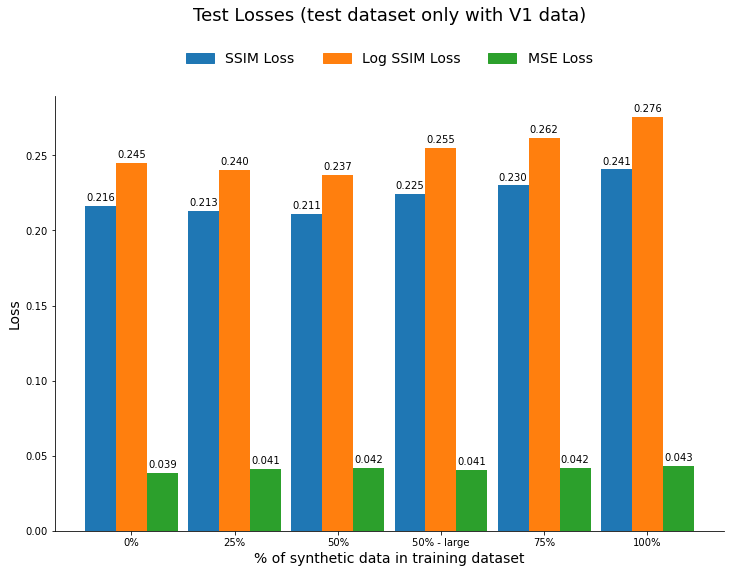

In [21]:
### bar plot of test losses
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

### grouped bar plot (run_dict["test_losses"] is a dict containing multiple losses)
bar_width = 0.9
losses_to_plot = [
    "SSIM Loss",
    "Log SSIM Loss",
    "MSE Loss",
]
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
]
for i, (k, run_dict) in enumerate(runs_to_compare.items()):
    for j, loss in enumerate(losses_to_plot):
        rects = ax.bar(
            i - bar_width / len(losses_to_plot) + j * bar_width / len(losses_to_plot),
            run_dict["test_losses"][loss],
            width=bar_width / len(losses_to_plot),
            color=colors[j],
        )
        autolabel(rects)

### add legend with color explanation
from matplotlib import patches as mpatches
ax.legend(
    handles=[
        mpatches.Patch(color=colors[i], label=loss)
        for i, loss in enumerate(losses_to_plot)
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.13),
    ncol=len(losses_to_plot),
    fontsize=14,
    frameon=False,
)

ax.set_title(
    "Test Losses (test dataset only with V1 data)",
    fontsize=18,
    pad=75,
)
ax.set_xticks(range(len(runs_to_compare)))
ax.set_xticklabels(runs_to_compare.keys())
ax.set_xlabel("% of synthetic data in training dataset", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.set_ylim(0, None)

# remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()